## Tracks ripple participation probability over epochs

In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib.ticker import AutoMinorLocator


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
def compress_repeated_epochs(epoch_df):
    match = np.zeros([epoch_df.environment.shape[0]])
    match[match == 0] = np.nan
    for i,ep in enumerate(epoch_df.environment[:-1]):
        if np.isnan(match[i]):
            # find match in current and next epoch
            if ep == epoch_df.environment.iloc[i+1]:
                match[i:i+2] = i
                # given match, see if there are more matches
                for match_i in np.arange(1,epoch_df.environment[:-1].shape[0]):
                    if i+1+match_i == epoch_df.environment.shape[0]:
                        break
                    if ep == epoch_df.environment.iloc[i+1+match_i]:

                        match[i:i+1+match_i+1] = i
                    else:
                        break

    for i in range(len(match)):
        if np.isnan(match[i]):
            match[i] = (i+1)*2000 # make nans large numbers that are unlikely to be real epoch

    # iter through each epoch indicator to get start and stop
    results = pd.DataFrame()
    no_nan_match = match[~np.isnan(match)]
    for m in pd.unique(no_nan_match):
        temp_dict = {'name': epoch_df[match==m].name.iloc[0],
                    'startTime':epoch_df[match==m].startTime.iloc[0],
                    'stopTime':epoch_df[match==m].stopTime.iloc[-1],
                    'environment':epoch_df[match==m].environment.iloc[0],
                    'behavioralParadigm':epoch_df[match==m].behavioralParadigm.iloc[0],
                    }
        temp_df = pd.DataFrame.from_dict(temp_dict,orient='index').T

        results = results.append(temp_df,ignore_index=True)
    return results
    
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df):

    # create empty dataframe to add metrics from each epoch
    df_save = pd.DataFrame()

    # create spike train object with ripple epochs
    st_unit_rip = st_unit[ripple_epochs]

    epochs = epoch_df.environment
    familiarity = epoch_df.behavioralParadigm

    for i,ep in enumerate(behavioral_epochs):
        temp_save = pd.DataFrame()

        unit_mat = get_participation(st_unit_rip[ep],
                                        ripple_epochs[ep])

        participation_prob = np.sum(unit_mat,axis=1) / unit_mat.shape[1]

        try:
            avg_fr_not_rip = st_unit[~ripple_epochs][ep].n_spikes / ep[~ripple_epochs].duration
            avg_fr_in_rip = st_unit_rip[ep].n_spikes / st_unit_rip[ep].support.duration
            n_spikes = st_unit[ep].n_spikes
        except:
            avg_fr_not_rip = np.nan
            avg_fr_in_rip = np.nan
            n_spikes = np.nan

        if participation_prob.shape[0] == 0:
            participation_prob = np.nan
            avg_fr_not_rip = np.nan
            avg_fr_in_rip = np.nan
            n_spikes = np.nan

        # if ripple_epochs[ep].n_intervals < 50:
        #     participation_prob = np.nan

        # package results and previously saved metrics
        temp_save['UID'] = cell_metrics.UID
        temp_save['basepath'] = basepath
        temp_save['epoch'] = epochs[i]
        temp_save['epoch_n'] = i
        temp_save['familiarity'] = familiarity[i]
        temp_save['deepSuperficial'] = cell_metrics.deepSuperficial
        temp_save['brainRegion'] = cell_metrics.brainRegion
        temp_save['putativeCellType'] = cell_metrics.putativeCellType
        temp_save['participation_prob'] = participation_prob
        temp_save['avg_fr_not_rip'] = avg_fr_not_rip
        temp_save['avg_fr_in_rip'] = avg_fr_in_rip
        temp_save['n_spikes'] = n_spikes
        temp_save['session_dur'] = ep.duration
        temp_save['n_ripples'] = ripple_epochs[ep].n_intervals

        df_save = df_save.append(temp_save,ignore_index=True)

    return df_save

def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = (
                    (cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False) 
                    )

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]
    
    if cell_metrics.shape[0] == 0:
        return

    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    # behavioral epochs
    epoch_df = loading.load_epoch(basepath)
    # some epochs will have repeating back to back sessions that are actually the same session
    epoch_df = compress_repeated_epochs(epoch_df)

    behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                    epoch_df.stopTime]).T])

    df_save = main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df)
    df_save.to_csv(save_file)

def participation_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)       

In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability'

# these datasets don't have multiple mazes in the same session (as far as I know)
not_to_use = (
            (df['basepath'].str.contains("GirardeauG", case=False)) |
            (df['basepath'].str.contains("ORproject", case=False)) |
            (df['basepath'].str.contains("OMLproject", case=False)) |
            (df['basepath'].str.contains("GrosmarkAD", case=False))
            )
df = df.loc[~not_to_use]

participation_run(df,save_path,parallel=True)

In [8]:
# df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

# big_epoch_df = pd.DataFrame()

# for basepath in df.basepath.unique():
#     # temp_df = loading.load_epoch(basepath)

#     try:
#         temp_df = loading.load_epoch(basepath)
#     except:
#         print(basepath)
#         temp_df = loading.load_epoch(basepath)

#         break
#     temp_df['basepath'] = basepath
#     big_epoch_df = big_epoch_df.append(temp_df,ignore_index=True)

In [9]:
# for basepath in big_epoch_df.basepath.unique():
#     big_epoch_df.loc[big_epoch_df.basepath == basepath,'n_epochs'] = big_epoch_df[big_epoch_df.basepath == basepath].shape[0]
# big_epoch_df[(big_epoch_df.n_epochs > 3) & (~big_epoch_df['basepath'].str.contains("GirardeauG", case=False))].basepath.unique()

# Load saved data

In [5]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(save_path)

# restrict to units with >=25 spikes per epoch

In [6]:
# restrict to units with >=25 spikes per epoch
for basepath in df.basepath.unique():
    good = []
    for ep in df[df.basepath == basepath].epoch_n.unique():
        good.append(df[(df.basepath == basepath) & (df.epoch_n==ep)].n_spikes >= 25)

    idx = np.vstack(good).sum(axis=0) == df[(df.basepath == basepath)].epoch_n.unique().shape[0]
    idx = np.hstack([idx]*df[(df.basepath == basepath)].epoch_n.unique().shape[0])
    df.loc[df.basepath == basepath, 'unit_quality'] = idx
df = df[df.unit_quality]
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality
0,0,1,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.008518,0.021722,0.142346,29.0,1139.9992,587,True
1,1,2,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Superficial,CA1,Pyramidal Cell,0.015332,0.044349,0.256223,58.0,1139.9992,587,True
2,2,9,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.126065,0.230796,2.590703,346.0,1139.9992,587,True
3,3,10,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Superficial,CA1,Pyramidal Cell,0.039182,0.264284,0.683262,316.0,1139.9992,587,True
4,4,12,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.766610,9.884389,39.401462,12305.0,1139.9992,587,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20192,111,31,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Deep,CA1,Pyramidal Cell,0.066334,0.134450,1.384265,2520.0,15573.4079,5216,True
20193,112,32,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Deep,CA1,Pyramidal Cell,0.024732,0.193009,0.436982,3089.0,15573.4079,5216,True
20195,114,35,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Deep,CA1,Pyramidal Cell,0.046012,0.089808,0.985409,1704.0,15573.4079,5216,True
20198,117,40,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Superficial,CA1,Pyramidal Cell,0.017446,0.017397,0.501503,436.0,15573.4079,5216,True


# remove sleep epochs

# Keep sessions with >= 25 ripples

In [7]:
# restrict to units with >=25 ripples per epoch
for basepath in df.basepath.unique():
    good = []
    for ep in df[df.basepath == basepath].epoch_n.unique():
        good.append(df[(df.basepath == basepath) & (df.epoch_n==ep)].n_ripples >= 25)

    idx = np.vstack(good).sum(axis=0) == df[(df.basepath == basepath)].epoch_n.unique().shape[0]
    idx = np.hstack([idx]*df[(df.basepath == basepath)].epoch_n.unique().shape[0])
    df.loc[df.basepath == basepath, 'epoch_quality'] = idx
df = df[df.epoch_quality]
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality,epoch_quality
0,0,1,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.008518,0.021722,0.142346,29.0,1139.9992,587,True,True
1,1,2,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Superficial,CA1,Pyramidal Cell,0.015332,0.044349,0.256223,58.0,1139.9992,587,True,True
2,2,9,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.126065,0.230796,2.590703,346.0,1139.9992,587,True,True
3,3,10,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Superficial,CA1,Pyramidal Cell,0.039182,0.264284,0.683262,316.0,1139.9992,587,True,True
4,4,12,Z:\Data\AYAold\AB1\day1,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.766610,9.884389,39.401462,12305.0,1139.9992,587,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20192,111,31,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Deep,CA1,Pyramidal Cell,0.066334,0.134450,1.384265,2520.0,15573.4079,5216,True,True
20193,112,32,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Deep,CA1,Pyramidal Cell,0.024732,0.193009,0.436982,3089.0,15573.4079,5216,True,True
20195,114,35,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Deep,CA1,Pyramidal Cell,0.046012,0.089808,0.985409,1704.0,15573.4079,5216,True,True
20198,117,40,Z:\Data\Kenji\nlx_070329,sleep,2,10.0,Superficial,CA1,Pyramidal Cell,0.017446,0.017397,0.501503,436.0,15573.4079,5216,True,True


# keep if more than one unique maze type

In [26]:
# keep = []
# for basepath in df.basepath:
#     keep.append(df[(df.basepath == basepath)].epoch.unique().shape[0] > 1) 
# df = df[keep]
# df    

# make sure the remaining sessions have more than one task that is not sleep

In [8]:
keep = []
for basepath in df.basepath:
    epoch_types = df[(df.basepath == basepath)].epoch.unique()
    keep.append(sum(epoch_types != 'sleep') > 1)
df = df[keep]
df    

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality,epoch_quality
114,0,1,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.355131,0.851347,8.197266,2632.0,2520.0,994,True,True
115,1,2,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.178068,0.499642,3.758967,1475.0,2520.0,994,True,True
116,2,3,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.400402,2.904931,8.423710,7686.0,2520.0,994,True,True
117,3,4,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.322938,1.486291,6.974469,4109.0,2520.0,994,True,True
118,4,5,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.185111,1.145997,3.411753,3038.0,2520.0,994,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19562,378,110,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.074742,0.166958,1.651338,1453.0,6721.5,3492,True,True
19563,379,111,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.135739,0.185577,3.109721,1899.0,6721.5,3492,True,True
19564,380,112,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.086483,0.342071,2.275077,2730.0,6721.5,3492,True,True
19565,381,113,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.083906,0.168650,1.835319,1505.0,6721.5,3492,True,True


In [9]:
print(df.epoch.unique())
print(df.epoch_n.unique())
print(df.familiarity.unique())
print(df.basepath.unique())

['sleep' 'tmaze' 'linear' 'openfield' 'linearOne' 'linearTwo' 'Tmaze'
 'wheel' 'bigSquare' 'Mwheel' 'plus' 'midSquare' 'wheel_home']
[0 1 2 3 4 5 6 7 8]
[ 1.  2. 10.  6.  8.  9.]
['Z:\\Data\\AYAold\\AB3\\AB3_38_41' 'Z:\\Data\\AYAold\\AB3\\AB3_42_46'
 'Z:\\Data\\AYAold\\AYA9\\day12' 'Z:\\Data\\Kenji\\2006-6-12'
 'Z:\\Data\\Kenji\\2006-6-13' 'Z:\\Data\\Kenji\\2006-6-7'
 'Z:\\Data\\Kenji\\ec013.152_157' 'Z:\\Data\\Kenji\\ec013.194_213'
 'Z:\\Data\\Kenji\\ec013.242_258' 'Z:\\Data\\Kenji\\ec013.370_390'
 'Z:\\Data\\Kenji\\ec013.393_418' 'Z:\\Data\\Kenji\\ec013.480_509'
 'Z:\\Data\\Kenji\\ec013.512_537' 'Z:\\Data\\Kenji\\ec013.540_561'
 'Z:\\Data\\Kenji\\ec013.564_585' 'Z:\\Data\\Kenji\\ec013.588_604'
 'Z:\\Data\\Kenji\\ec013.656_674' 'Z:\\Data\\Kenji\\ec013.677_699'
 'Z:\\Data\\Kenji\\ec013.702_724' 'Z:\\Data\\Kenji\\ec013.733_746'
 'Z:\\Data\\Kenji\\ec013.752_769' 'Z:\\Data\\Kenji\\ec013.779_791'
 'Z:\\Data\\Kenji\\ec013.816_835' 'Z:\\Data\\Kenji\\ec013.853_866'
 'Z:\\Data\\Kenji\\ec014.71

# list out epochs

In [10]:
for basepath in df.basepath.unique():
    temp_df = df[df.basepath == basepath]
    epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]
    print(basepath,epoch_name)

Z:\Data\AYAold\AB3\AB3_38_41 ['sleep', 'tmaze', 'sleep', 'linear']
Z:\Data\AYAold\AB3\AB3_42_46 ['sleep', 'tmaze', 'sleep', 'linear']
Z:\Data\AYAold\AYA9\day12 ['linear', 'sleep', 'openfield']
Z:\Data\Kenji\2006-6-12 ['sleep', 'linearOne', 'linearTwo', 'sleep', 'Tmaze', 'sleep']
Z:\Data\Kenji\2006-6-13 ['sleep', 'linearOne', 'linearTwo', 'wheel', 'Tmaze']
Z:\Data\Kenji\2006-6-7 ['linearOne', 'sleep', 'linearTwo', 'sleep']
Z:\Data\Kenji\ec013.152_157 ['sleep', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.194_213 ['sleep', 'bigSquare', 'sleep', 'linear', 'sleep']
Z:\Data\Kenji\ec013.242_258 ['sleep', 'bigSquare', 'linear', 'sleep']
Z:\Data\Kenji\ec013.370_390 ['sleep', 'linear', 'sleep', 'wheel', 'sleep', 'bigSquare', 'linear', 'sleep']
Z:\Data\Kenji\ec013.393_418 ['sleep', 'linear', 'sleep', 'wheel', 'bigSquare', 'sleep', 'bigSquare', 'linear', 'sleep']
Z:\Data\Kenji\ec013.480_509 ['sleep', 'Mwheel', 'sleep', 'plus', 'sleep', 'bigSquare', 'linear', 'sleep']
Z:\Data\Kenji\ec013.512_537 ['s

In [11]:
n_units = [df[df.basepath == basepath].UID.unique().shape[0] for basepath in df.basepath.unique()]
print(len(n_units),' sessions')
print(sum(n_units),' units')


30  sessions
584  units


In [12]:
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality,epoch_quality
114,0,1,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.355131,0.851347,8.197266,2632.0,2520.0,994,True,True
115,1,2,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.178068,0.499642,3.758967,1475.0,2520.0,994,True,True
116,2,3,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.400402,2.904931,8.423710,7686.0,2520.0,994,True,True
117,3,4,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.322938,1.486291,6.974469,4109.0,2520.0,994,True,True
118,4,5,Z:\Data\AYAold\AB3\AB3_38_41,sleep,0,1.0,Deep,CA1,Pyramidal Cell,0.185111,1.145997,3.411753,3038.0,2520.0,994,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19562,378,110,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.074742,0.166958,1.651338,1453.0,6721.5,3492,True,True
19563,379,111,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.135739,0.185577,3.109721,1899.0,6721.5,3492,True,True
19564,380,112,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.086483,0.342071,2.275077,2730.0,6721.5,3492,True,True
19565,381,113,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.083906,0.168650,1.835319,1505.0,6721.5,3492,True,True


# calculate standard deviation of participation probability over epochs

In [192]:
temp_df = df[df.basepath == 'Z:\Data\AYAold\AB3\AB3_38_41']
X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
for i,ep in enumerate(temp_df.epoch_n.unique()):
    X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values
    

In [212]:
temp_df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality,epoch_quality
19184,0,15,Z:\Data\Kenji\i01_maze15_MS.001_004,bigSquare,0,10.0,Deep,CA1,Pyramidal Cell,0.026549,0.092492,0.280815,346.0,3719.1,113,True,True
19186,2,17,Z:\Data\Kenji\i01_maze15_MS.001_004,bigSquare,0,10.0,Deep,CA1,Pyramidal Cell,0.035398,0.057437,0.468025,218.0,3719.1,113,True,True
19189,5,21,Z:\Data\Kenji\i01_maze15_MS.001_004,bigSquare,0,10.0,Deep,CA1,Pyramidal Cell,0.106195,0.261837,1.778493,990.0,3719.1,113,True,True
19190,6,22,Z:\Data\Kenji\i01_maze15_MS.001_004,bigSquare,0,10.0,Deep,CA1,Pyramidal Cell,0.053097,0.048538,0.561629,186.0,3719.1,113,True,True
19192,8,24,Z:\Data\Kenji\i01_maze15_MS.001_004,bigSquare,0,10.0,Deep,CA1,Pyramidal Cell,0.256637,1.534347,5.709900,5751.0,3719.1,113,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19562,378,110,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.074742,0.166958,1.651338,1453.0,6721.5,3492,True,True
19563,379,111,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.135739,0.185577,3.109721,1899.0,6721.5,3492,True,True
19564,380,112,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.086483,0.342071,2.275077,2730.0,6721.5,3492,True,True
19565,381,113,Z:\Data\Kenji\i01_maze15_MS.001_004,sleep,3,10.0,Deep,CA1,Pyramidal Cell,0.083906,0.168650,1.835319,1505.0,6721.5,3492,True,True


[0.03539823 0.03723404 0.02847571 0.04209622]


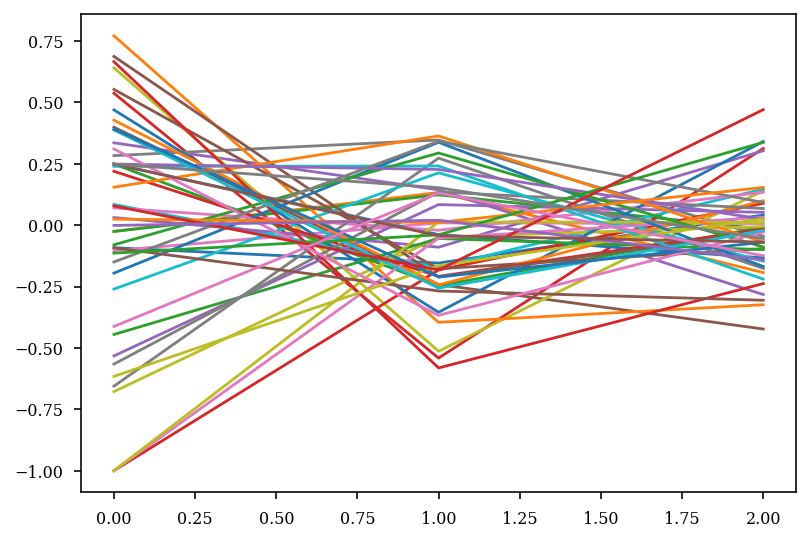

In [244]:
def get_stepwise_ratio(x):
    return [(x[i] - x[i+1]) / (x[i] + x[i+1]) for i in range(len(x)-1)]
        
print(X_participation_prob[:,1])

stepwise_ratio = get_stepwise_ratio(X_participation_prob)    
plt.plot(stepwise_ratio)
plt.show()

In [476]:
def get_stepwise_ratio(x):
    return [(x[i] - x[i+1]) / (x[i] + x[i+1]) for i in range(len(x)-1)]
        
df_save = pd.DataFrame()
for basepath in df.basepath.unique():
    temp_df = df[df.basepath == basepath]
    X_participation_prob = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
    X_avgfr = np.zeros_like(X_participation_prob)
    for i,ep in enumerate(temp_df.epoch_n.unique()):
        X_participation_prob[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values
        X_avgfr[i,:] = temp_df[temp_df.epoch_n == ep].avg_fr_in_rip.values

    stepwise_ratio_par = get_stepwise_ratio(X_participation_prob)    

    temp_df_idx = temp_df.epoch_n == temp_df.epoch_n.unique()[0]
    temp_df_ = pd.DataFrame()
    
    temp_df_['baseline_par'] = X_participation_prob[0,:]
    temp_df_['baseline_fr'] = X_avgfr[0,:]

    temp_df_['par_mean_diff'] = np.nanmean(np.diff(X_participation_prob,axis=0),axis=0)
    temp_df_['par_std'] = np.nanstd(X_participation_prob,axis=0)
    temp_df_['par_cv'] = np.nanstd(X_participation_prob,axis=0) / np.nanmean(X_participation_prob,axis=0)
    temp_df_['par_cv_raw'] = np.sqrt(np.exp(np.nanstd(np.log(X_participation_prob),axis=0)**2)-1)
    temp_df_['par_mean'] = np.nanmean(X_participation_prob,axis=0)
    temp_df_['par_median'] = np.nanmedian(X_participation_prob,axis=0)

    temp_df_['par_mean_diff_stepwise_ratio'] = np.nanmean(np.diff(stepwise_ratio_par,axis=0),axis=0)
    temp_df_['par_std_stepwise_ratio'] = np.nanstd(stepwise_ratio_par,axis=0)
    temp_df_['par_mean_stepwise_ratio'] = np.nanmean(stepwise_ratio_par,axis=0)
    temp_df_['par_median_stepwise_ratio'] = np.nanmedian(stepwise_ratio_par,axis=0)

    temp_df_['fr_mean_diff'] = np.nanmean(np.diff(X_avgfr,axis=0),axis=0)
    temp_df_['fr_std'] = np.nanstd(X_avgfr,axis=0)
    temp_df_['fr_mean'] = np.nanmean(X_avgfr,axis=0)
    temp_df_['fr_median'] = np.nanmedian(X_avgfr,axis=0)

    temp_df_['basepath'] = basepath
    temp_df_['UID'] = temp_df[temp_df_idx].UID.values
    temp_df_['deepSuperficial'] = temp_df[temp_df_idx].deepSuperficial.values
    temp_df_['n_spikes_mean'] = temp_df[temp_df_idx].n_spikes.values
    temp_df_['avg_fr_not_rip'] = temp_df[temp_df_idx].avg_fr_not_rip.values
    temp_df_['avg_fr_in_rip'] = temp_df[temp_df_idx].avg_fr_in_rip.values
    temp_df_['mean_n_ripples'] = temp_df.n_ripples.mean()

    df_save = df_save.append(temp_df_,ignore_index=True)
df_save

C:\Users\Cornell\AppData\Local\Temp/ipykernel_15436/13518189.py:24: RuntimeWarning: divide by zero encountered in log
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15436/13518189.py:24: RuntimeWarning: divide by zero encountered in log
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15436/13518189.py:24: RuntimeWarning: divide by zero encountered in log
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15436/13518189.py:2: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15436/13518189.py

,baseline_par,baseline_fr,par_mean_diff,par_std,par_cv,par_cv_raw,par_mean,par_median,par_mean_diff_stepwise_ratio,par_std_stepwise_ratio,...,fr_std,fr_mean,fr_median,basepath,UID,deepSuperficial,n_spikes_mean,avg_fr_not_rip,avg_fr_in_rip,mean_n_ripples
0,0.355131,8.197266,-0.061559,0.070947,0.281938,0.286670,0.251641,0.240490,-0.015953,0.190220,...,1.714407,5.863521,5.950807,Z:\Data\AYAold\AB3\AB3_38_41,1,Deep,2632.0,0.851347,8.197266,447.0
1,0.178068,3.758967,0.001250,0.027960,0.172797,0.196457,0.161810,0.175892,-0.121835,0.176051,...,0.756483,3.378877,3.649823,Z:\Data\AYAold\AB3\AB3_38_41,2,Deep,1475.0,0.499642,3.758967,447.0
2,0.400402,8.423710,-0.046346,0.063374,0.216358,0.201127,0.292913,0.267045,-0.119112,0.097255,...,1.416997,6.568050,6.497357,Z:\Data\AYAold\AB3\AB3_38_41,3,Deep,7686.0,2.904931,8.423710,447.0
3,0.322938,6.974469,0.024930,0.089428,0.325084,0.336932,0.275092,0.260411,-0.307552,0.251206,...,2.908513,6.212965,5.527228,Z:\Data\AYAold\AB3\AB3_38_41,4,Deep,4109.0,1.486291,6.974469,447.0
4,0.185111,3.411753,-0.012461,0.016786,0.100635,0.101350,0.166806,0.167193,0.003573,0.035442,...,0.289648,2.960109,2.901241,Z:\Data\AYAold\AB3\AB3_38_41,5,Deep,3038.0,1.145997,3.411753,447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0.168142,2.714542,-0.031133,0.048361,0.325549,0.396312,0.148552,0.155879,0.196044,0.268438,...,1.783714,3.510584,2.977105,Z:\Data\Kenji\i01_maze15_MS.001_004,110,Deep,1490.0,0.393969,2.714542,1097.5
580,0.106195,2.059308,0.009848,0.013451,0.119433,0.113114,0.112624,0.106289,-0.070089,0.071560,...,0.384592,2.518195,2.451875,Z:\Data\Kenji\i01_maze15_MS.001_004,111,Deep,2451.0,0.654996,2.059308,1097.5
581,0.115044,1.216864,-0.009520,0.017604,0.203479,0.194766,0.086513,0.080930,-0.158894,0.144167,...,0.381068,1.772993,1.800015,Z:\Data\Kenji\i01_maze15_MS.001_004,112,Deep,1309.0,0.349475,1.216864,1097.5
582,0.035398,0.374420,0.016169,0.020090,0.297914,0.367087,0.067434,0.074616,0.144000,0.222209,...,0.657105,1.510108,1.855458,Z:\Data\Kenji\i01_maze15_MS.001_004,113,Deep,60.0,0.015101,0.374420,1097.5


# task to task participation variability

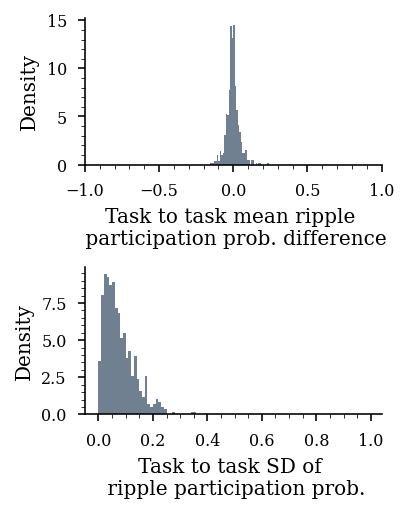

In [186]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.45, subplots=(2,.9)), edgecolor='k')
fig.subplots_adjust(hspace = 0.7, wspace=.5)
axs = axs.ravel()

axs[0].hist(df_save.par_mean_diff,bins = np.arange(-1,1,.01),color='slategrey',density=True)
axs[0].set_xlim(-1,1)
axs[0].set_xlabel('Task to task mean ripple \n participation prob. difference')
axs[0].set_ylabel('Density')

axs[1].hist(df_save.par_std,bins = np.arange(0,1,.01),color='slategrey',density=True)
axs[1].set_xlabel('Task to task SD of \n ripple participation prob.')
axs[1].set_ylabel('Density')

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'participation_mean_diff_over_epochs_w_sleep.svg'),dpi=300,bbox_inches='tight')

# task to task firing rate variability

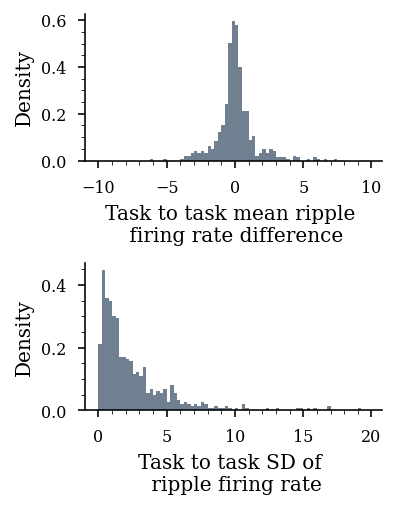

In [230]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.45, subplots=(2,.9)), edgecolor='k')
fig.subplots_adjust(hspace = 0.7, wspace=.5)
axs = axs.ravel()

axs[0].hist(df_save.fr_mean_diff,bins = np.arange(-10,10,.25),color='slategrey',density=True)
axs[0].set_xlabel('Task to task mean ripple \n firing rate difference')
axs[0].set_ylabel('Density')

axs[1].hist(df_save.fr_std,bins = np.arange(0,20,.25),color='slategrey',density=True)
axs[1].set_xlabel('Task to task SD of \n ripple firing rate')
axs[1].set_ylabel('Density')

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

# plt.savefig(os.path.join(fig_save_path,'participation_mean_diff_over_epochs_w_sleep.svg'),dpi=300,bbox_inches='tight')

# task to task stepwise ratio variability

$ratio = \frac{participation_{task n} - participation_{task n+1}}{participation_{task n} + participation_{task n+1}} $

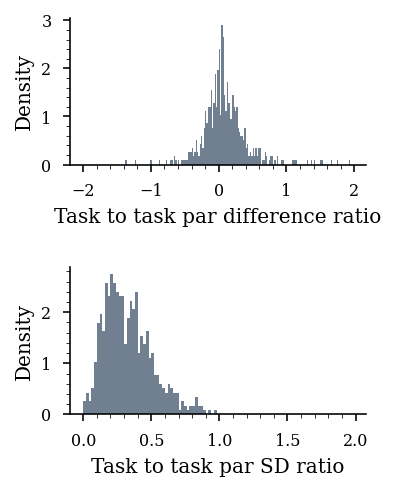

In [471]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.45, subplots=(2,.9)), edgecolor='k')
fig.subplots_adjust(hspace = 0.7, wspace=.5)
axs = axs.ravel()

axs[0].hist(df_save.par_mean_diff_stepwise_ratio,bins = np.arange(-2,2,.02),color='slategrey',density=True)
axs[0].set_xlabel('Task to task par difference ratio')
axs[0].set_ylabel('Density')

axs[1].hist(df_save.par_std_stepwise_ratio,bins = np.arange(0,2,.02),color='slategrey',density=True)
axs[1].set_xlabel('Task to task par SD ratio')
axs[1].set_ylabel('Density')

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())


In [278]:
df_save.keys()

Index(['par_mean_diff', 'par_std', 'par_mean', 'par_median',
       'par_mean_diff_stepwise_ratio', 'par_std_stepwise_ratio',
       'par_mean_stepwise_ratio', 'par_median_stepwise_ratio', 'fr_mean_diff',
       'fr_std', 'fr_mean', 'fr_median', 'basepath', 'UID', 'deepSuperficial',
       'n_spikes_mean', 'avg_fr_not_rip', 'avg_fr_in_rip', 'mean_n_ripples',
       'avg_fr_not_rip_log'],
      dtype='object')

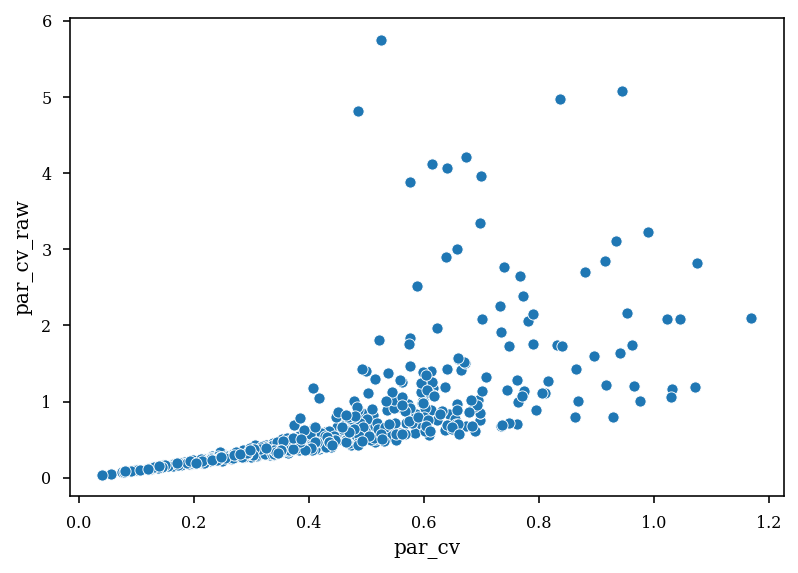

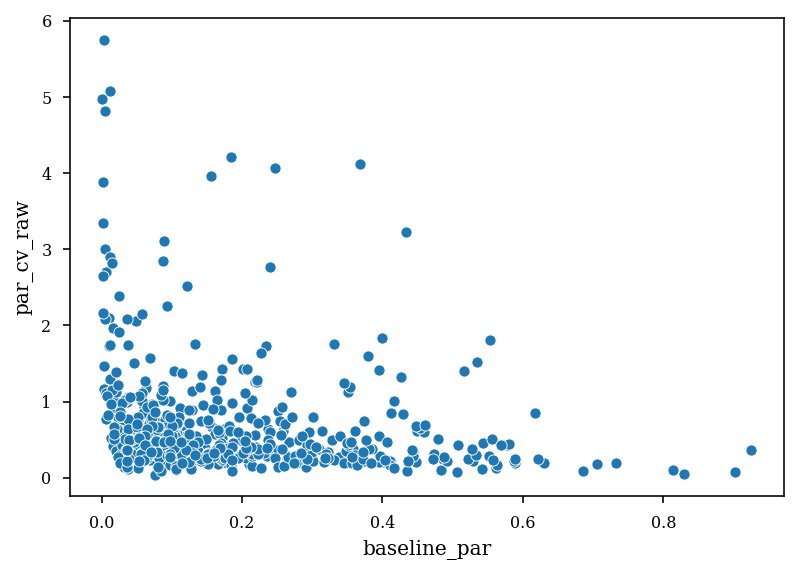

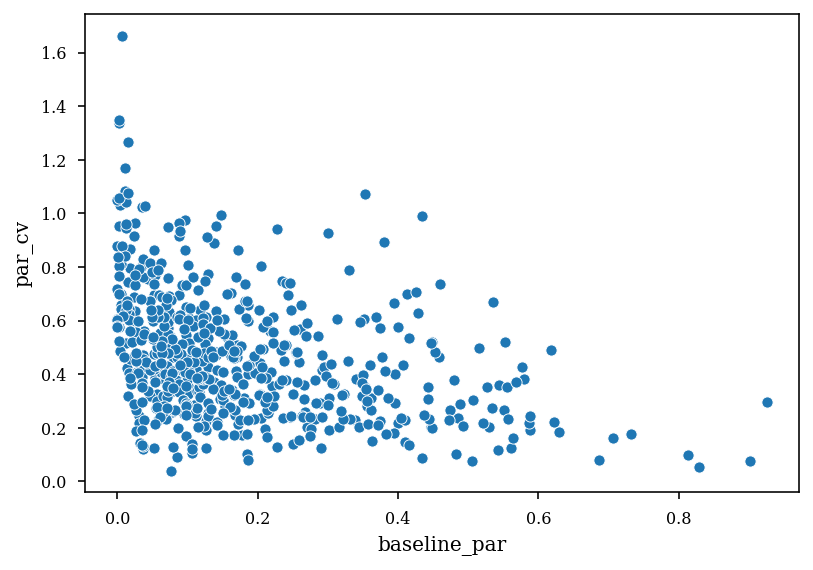

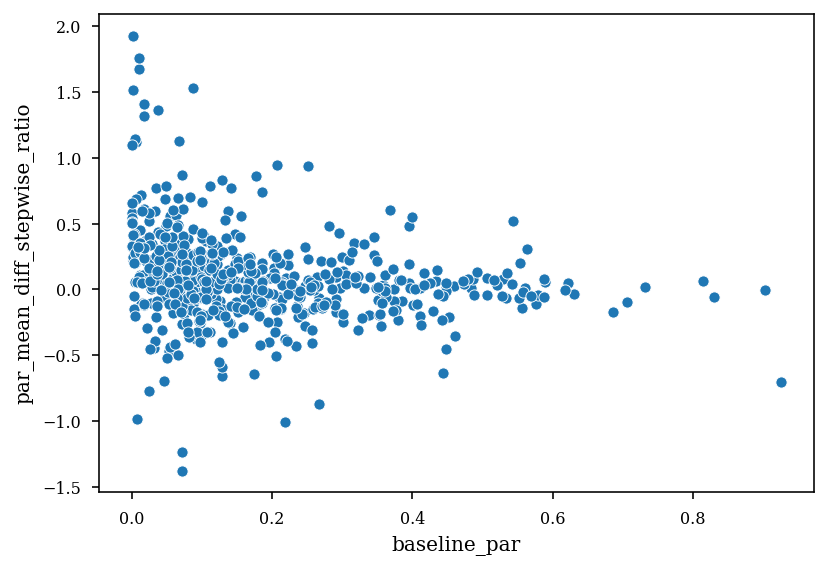

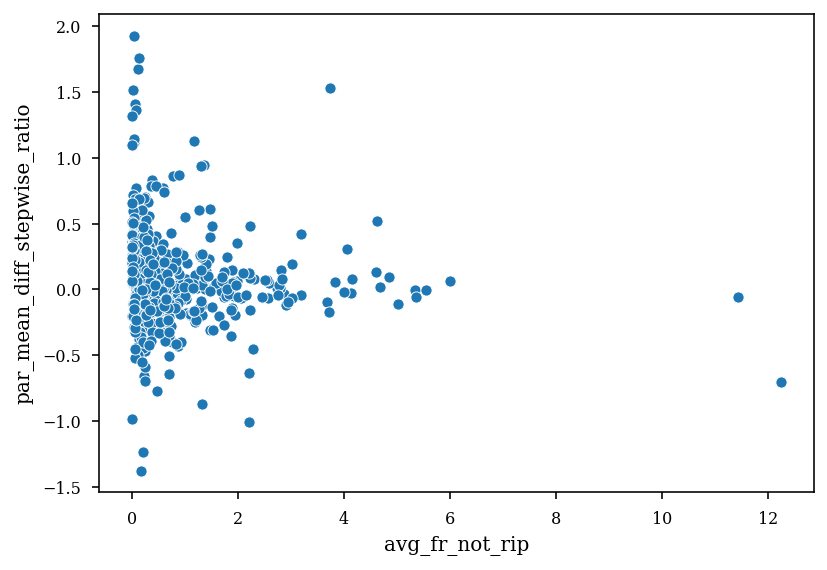

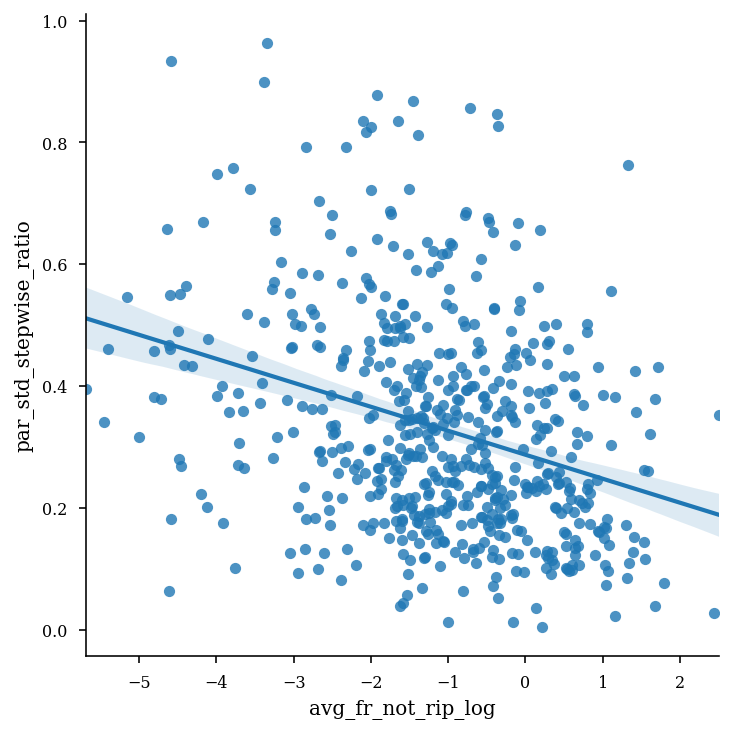

In [479]:
sns.scatterplot(x="par_cv", y="par_cv_raw",data=df_save)
plt.show()

sns.scatterplot(x="baseline_par", y="par_cv_raw",data=df_save)
plt.show()

sns.scatterplot(x="baseline_par", y="par_cv",data=df_save)
plt.show()

sns.scatterplot(x="baseline_par", y="par_mean_diff_stepwise_ratio",data=df_save)
# plt.axhline(0)
plt.show()

sns.scatterplot(x="avg_fr_not_rip", y="par_mean_diff_stepwise_ratio",data=df_save)
# plt.axhline(0)
plt.show()

df_save['avg_fr_not_rip_log'] = np.log(df_save.avg_fr_not_rip)
sns.lmplot(x="avg_fr_not_rip_log", y="par_std_stepwise_ratio",data=df_save)
plt.show()


<AxesSubplot:xlabel='deepSuperficial', ylabel='par_std'>

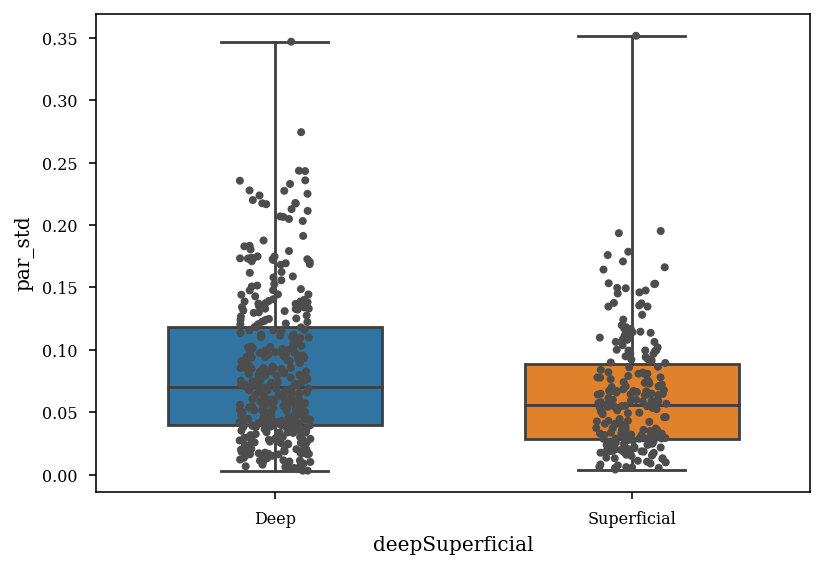

In [15]:
sns.boxplot(x="deepSuperficial", y="par_std", data=df_save,
            whis=[0, 100], width=.6)

sns.stripplot(x="deepSuperficial", y="par_std", data=df_save,
              size=4, color=".3", linewidth=0)

# population plot over epochs

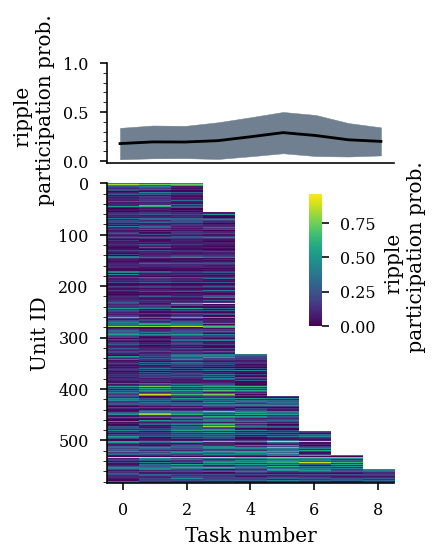

In [183]:
X_ = []
for u in range(df_save.shape[0]):
    X_.append(df[(df.basepath == df_save.iloc[u].basepath) & (df.UID == df_save.iloc[u].UID)].participation_prob.values)

X = np.zeros([len(X_),9])
X[X==0] = np.nan
for i,x in enumerate(X_):
    X[i,0:len(x)] = x
    
n_empty = [sum(np.isnan(x)) for x in X]

fig, axs = plt.subplots(2, 1, figsize=functions.set_size('thesis', fraction=.5, subplots=(2,1)),gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace = 0.1, wspace=0)
axs = axs.ravel()

X_nan = X.copy()
X_nan[X_nan==0] = np.nan

sem = np.nanstd(X_nan,axis=0) / np.sqrt(len(X_nan))
# y1,y2 = st.t.interval(alpha=0.95, df=len(X_nan)-1, loc=np.nanmean(X_nan,axis=0), scale=sem) 
# axs[0].fill_between(np.arange(X_nan.shape[1]),y2,y1,color='slategrey',label='95% CI')
sd = np.nanstd(X_nan,axis=0)

axs[0].fill_between(np.arange(X_nan.shape[1]),np.nanmean(X_nan,axis=0)-sd,np.nanmean(X_nan,axis=0)+sd,color='slategrey',label='$\pm sd$')
axs[0].plot(np.arange(X_nan.shape[1]),np.nanmean(X_nan,axis=0),color='k',label='mean')
axs[0].set_ylim(-.02,1)
axs[0].set_ylabel('ripple \n participation prob.')
axs[0].get_xaxis().set_visible(False)
# axs[0].legend(loc='best',frameon=False)

im = axs[1].imshow(X[np.argsort(-np.array(n_empty))],aspect='auto',interpolation='nearest')
axs[1].set_xlabel('Task number')
axs[1].set_ylabel('Unit ID')


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.6, 0.40, 0.03, 0.25])
cbar = plt.colorbar(im,cax=cax)
cbar.set_label('ripple \n participation prob.', labelpad=5)
cbar.outline.set_visible(False)

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'participation_mean_over_epochs.svg'),dpi=300,bbox_inches='tight')

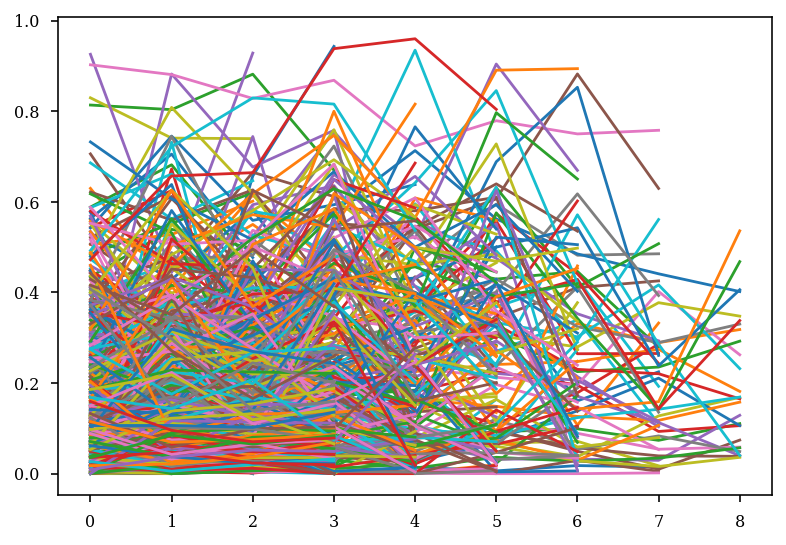

In [17]:
particip_mat = np.zeros(df_save.shape[0],9)
plt.figure()
for u in range(df_save.shape[0]):
    plt.plot(df[(df.basepath == df_save.iloc[u].basepath) & (df.UID == df_save.iloc[u].UID)].participation_prob.values)


# look at correlations within ripples

In [463]:

basepath = r'Z:\Data\AYAold\AYA9\day12'

cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)
epoch_df = loading.load_epoch(basepath)
epoch_df = compress_repeated_epochs(epoch_df)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))
# restric cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

# idx = (cell_metrics.deepSuperficial=="Superficial")
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object), fs=fs_dat)

behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [464]:
def get_ripple_fr(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

unit_mat = []
for i in range(behavioral_epochs.n_intervals):
    unit_mat.append(get_ripple_fr(st_unit[behavioral_epochs[i]][ripple_epochs],ripple_epochs[behavioral_epochs[i]]))

# unit_mat = []
# for i in range(behavioral_epochs.n_intervals):
#     unit_mat.append(get_participation(st_unit[behavioral_epochs[i]][ripple_epochs],ripple_epochs[behavioral_epochs[i]]))


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [432]:
unit_mat_all = get_participation(st_unit[ripple_epochs],ripple_epochs)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


<AxesSubplot:>

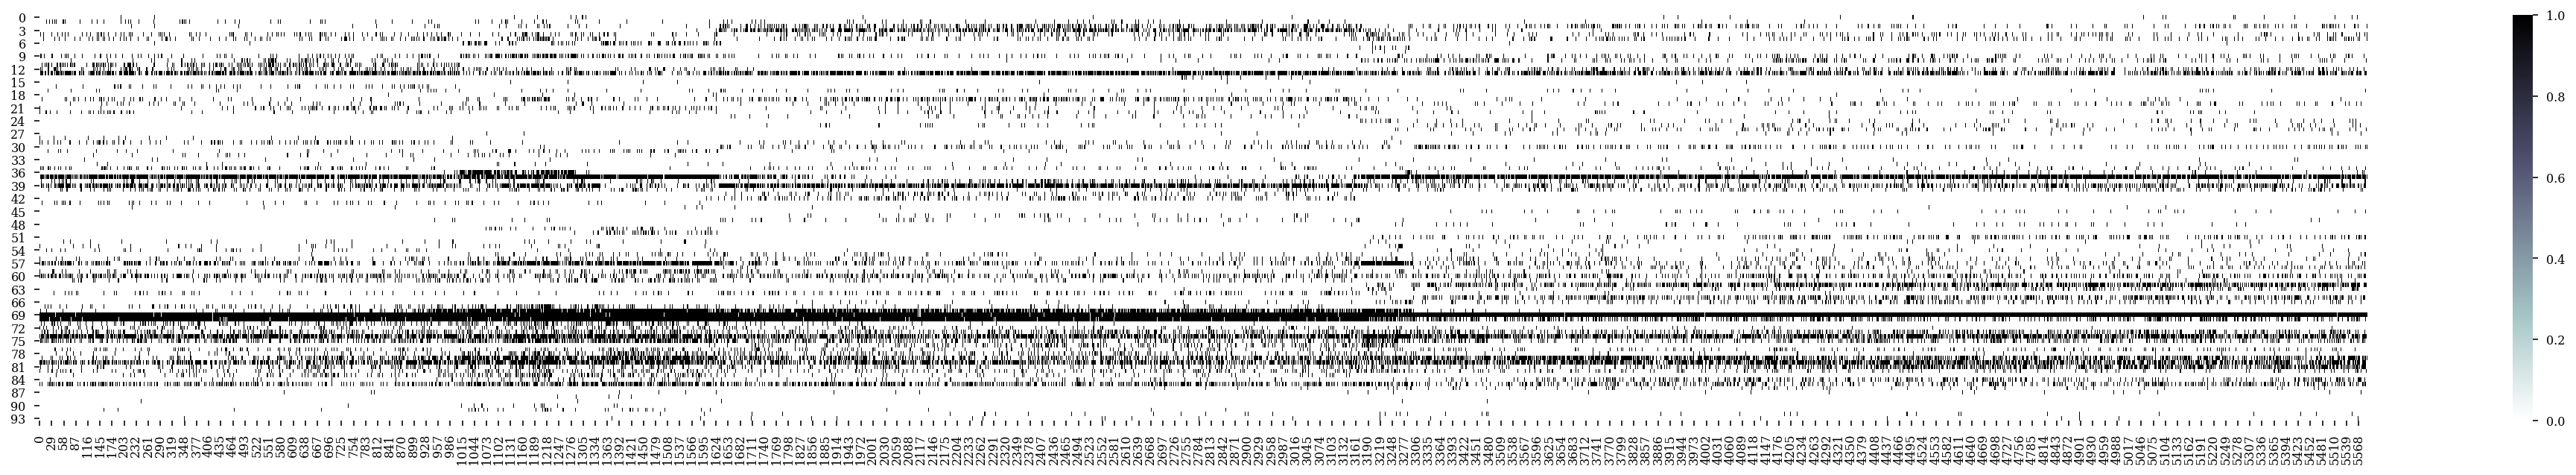

In [427]:
plt.figure(figsize=(35,5))
unit_mat_all_df = pd.DataFrame(index = np.arange(unit_mat_all.shape[0]), columns = np.arange(unit_mat_all.shape[1]))
unit_mat_all_df[:] = unit_mat_all
sns.heatmap(unit_mat_all_df,cmap="bone_r")

# plt.axvline(500,color='r')

# for be in behavioral_epochs:
#     plt.axvline(be.start,color='r')

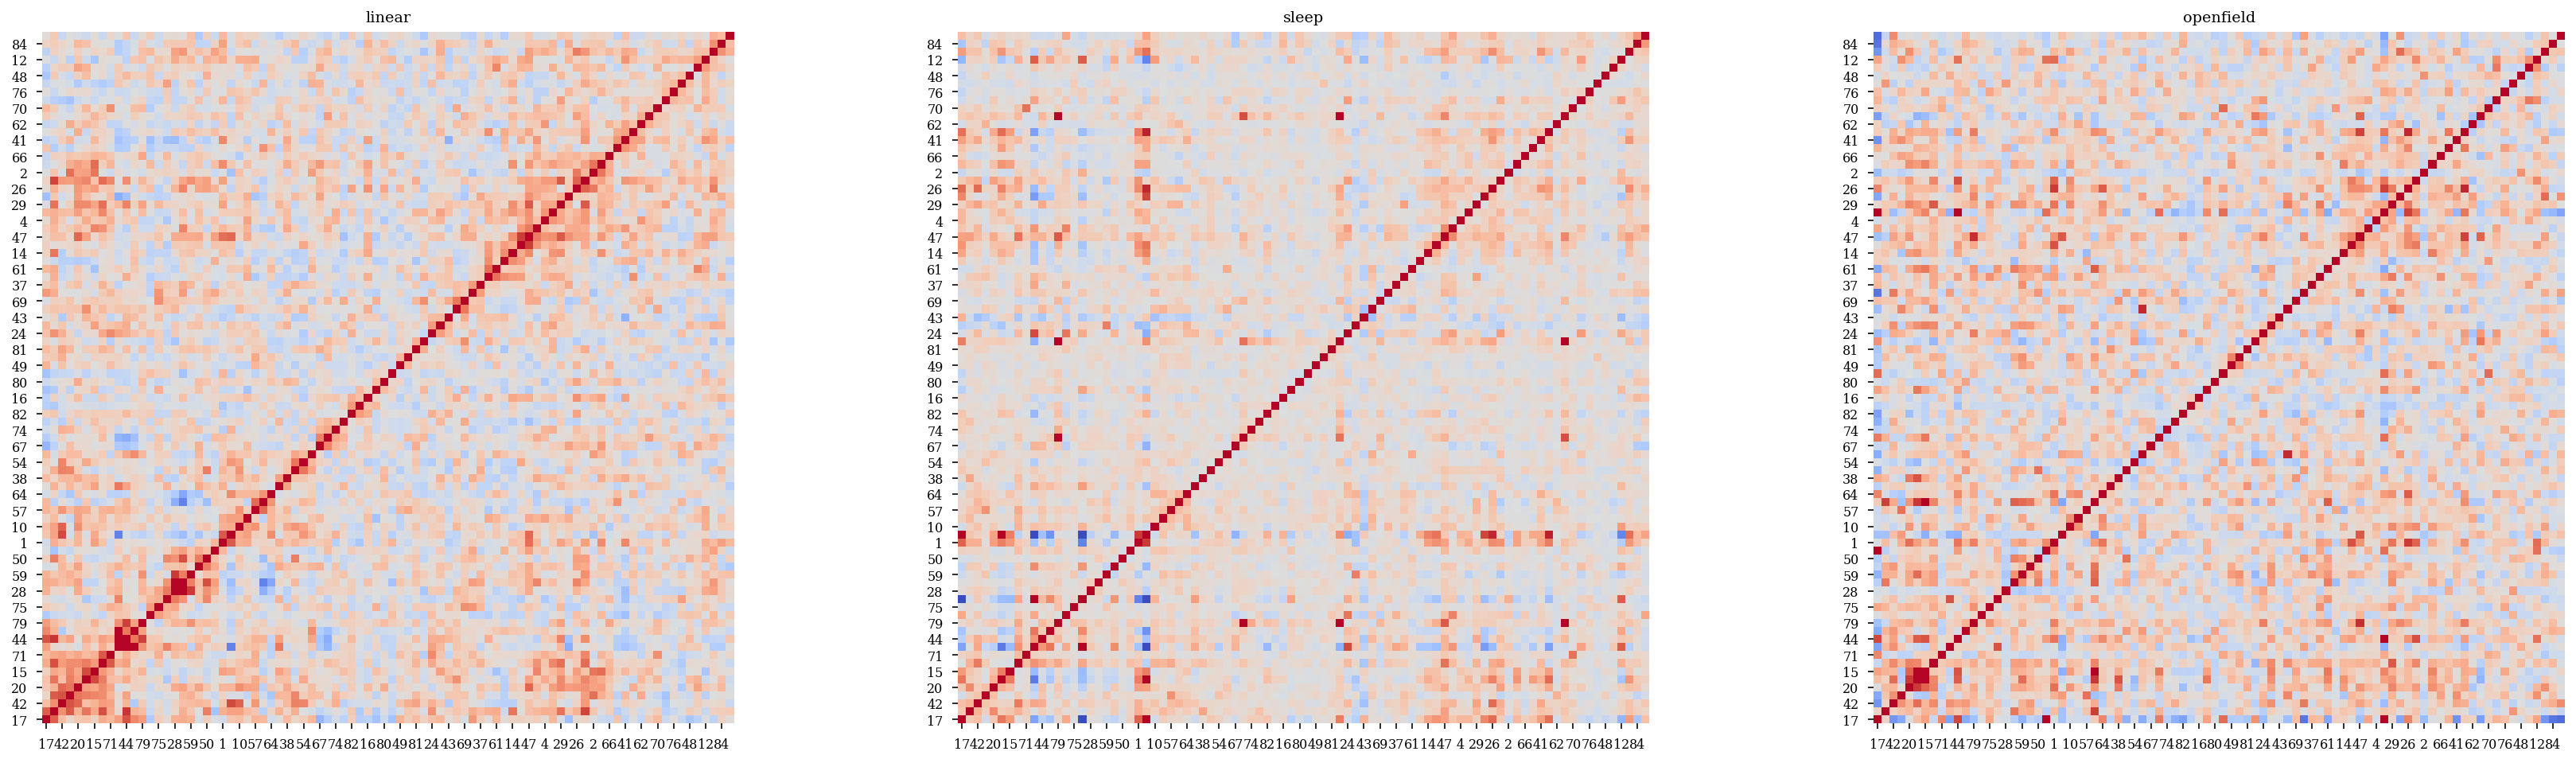

In [469]:
import scipy.cluster.hierarchy as sch

def get_corr_matrix(unit_mat):
    unit_mat_df_transpose = pd.DataFrame(index = np.arange(unit_mat.shape[1]), columns = np.arange(unit_mat.shape[0]))
    unit_mat_df_transpose[:] = unit_mat.T
    return unit_mat_df_transpose.corr(method="spearman")

def cluster_corr(corr_array):
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')    
    return np.argsort(idx_to_cluster_array)


fig, axs = plt.subplots(1,behavioral_epochs.n_intervals,figsize=(30,8), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.1)
axs = axs.ravel()

# remove_idx = np.sum(unit_mat[0] == 0,axis=1) == unit_mat[0].shape[1]
# remove_idx = sum(np.vstack(empty_)) > 0
# remove_idx = pd.unique(np.hstack(good_unit))
remove_idx = (
        (np.sum(unit_mat[0] > 0,axis=1)>10) &
        (np.sum(unit_mat[1] > 0,axis=1)>10) &
        (np.sum(unit_mat[2] > 0,axis=1)>10)
        )
# remove_idx = idx

unit_mat_corr = get_corr_matrix(unit_mat[0][remove_idx,:])
idx = cluster_corr(unit_mat_corr)

# cbar = False
for i in range(behavioral_epochs.n_intervals):
    # if i == behavioral_epochs.n_intervals-1:
    #     cbar = True
    unit_mat_corr = get_corr_matrix(unit_mat[i][remove_idx,:])
    unit_mat_corr[np.isnan(unit_mat_corr)] = 0
    sns.heatmap(unit_mat_corr.iloc[idx, :].T.iloc[idx, :],ax=axs[i],vmin=-.3,vmax=.3,cbar=False,cmap='coolwarm')
    # sns.heatmap(unit_mat_corr,ax=axs[i],vmin=-.1,vmax=.3)
    axs[i].set_aspect('equal','box')
    axs[i].invert_yaxis() 
    axs[i].set_title(epoch_df.environment[i])

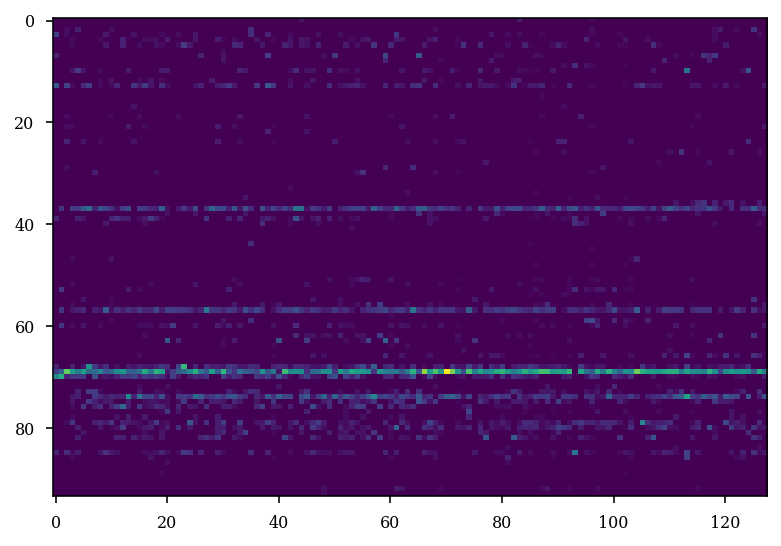

In [459]:
plt.imshow(unit_mat[3],aspect='auto',interpolation='nearest')

# code for plotting ripple raster with epochs

In [15]:
def get_raster_points(spikes,peak_time,duration=0.150):
    ''' 
    create raster centered over each ripple with a 1 second window
    '''
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - duration) & (spikes < r + duration)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i) 
        else:      
            x.append([np.nan])
            y.append([1+i])
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

def get_h0_z_energy(x,y,duration=0.150,bin_count=150,window=30):
     # bin cell into 5ms bins 
    bins = np.linspace(-duration,duration,bin_count)
    h0_counts, bin_edges = np.histogram(x, bins=bins)
    # normalize into firing rate
    h0 = h0_counts / (len(np.unique(y))*np.diff(bins)[0])
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,window)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, h0_counts

def plot_psth(ripples,epoch_df,spikes,epoch_n,ax):
    duration = 0.150
    bin_count = 150
    bins_edges = np.linspace(-duration,duration,bin_count)
    bin_width = np.diff(bins_edges)[0]

    peak_time = ripples.peaks
    peak_time = peak_time[(peak_time >= epoch_df.iloc[epoch_n].startTime) & (peak_time <= epoch_df.iloc[epoch_n].stopTime)]
    x, y = get_raster_points(spikes,peak_time)  
    h0, z, swr_energy, h0_counts = get_h0_z_energy(x,y)

    ax[epoch_n].plot(bins_edges[:-1]+bin_width/2,h0,color='k',linewidth=.5)
    ax[epoch_n+epoch_df.shape[0]].scatter(x,y,color='k',s=1,rasterized=True)

    ax[epoch_n].set_title(epoch_df.iloc[epoch_n].environment)

def get_unit_par(ripples,spikes):
    unit_particip = np.zeros(ripples.shape[0])
    unit_fr= np.zeros_like(unit_particip)

    for i,rip in enumerate(ripples.itertuples()):
        unit_particip[i] = np.any((spikes >= rip.start) & (spikes <= rip.stop))
        unit_fr[i] = np.sum((spikes >= rip.start) & (spikes <= rip.stop)) / rip.duration

    # unit_particip_sm = gaussian_filter1d(unit_particip,10)
    unit_particip_sm = gaussian_filter1d(unit_particip,30)
    return unit_particip,unit_fr,unit_particip_sm

def plot_epoched_ripple_spikes(epoch_df,spikes):
    X = []
    Y = []
    for epoch_n in range(epoch_df.shape[0]):
        peak_time = ripples.peaks
        peak_time = peak_time[(peak_time >= epoch_df.iloc[epoch_n].startTime) & (peak_time <= epoch_df.iloc[epoch_n].stopTime)]
        x, y = get_raster_points(spikes,peak_time)  
        X.append(x)
        Y.append(y)

    X = np.array(X,dtype=object)
    Y = np.array(Y,dtype=object)

    y_adj = []
    y_adj.append(Y[0])
    for i in np.arange(1,len(X)):
        try:
            y_adj.append(Y[i] + np.max(y_adj[i-1]))
        except:
            y_adj.append(Y[i])

    fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1.5,1)), edgecolor='k')
    fig.subplots_adjust(hspace = 0.1, wspace=0.05)
    axs = axs.ravel()

    for i in np.arange(0,len(X)):
        if epoch_df.iloc[i].environment == "sleep":
            axs[0].scatter(X[i],y_adj[i],s=1,color="k",label=epoch_df.iloc[i].environment)  
        else:
            axs[0].scatter(X[i],y_adj[i],s=1,label=epoch_df.iloc[i].environment)  

    axs[0].spines["right"].set_visible(False)
    axs[0].spines["top"].set_visible(False)
    # axs[0].legend(bbox_to_anchor=(1, .1, 0.5, .5),frameon=False,ncol=5,labelspacing=.1)
    axs[0].legend(bbox_to_anchor=[1.6, 1.01], loc='center right',frameon=False,ncol=3,labelspacing=.1,markerscale=4)
    #  bbox_to_anchor=(0.5, 0., 0.5, 0.5)
    axs[0].set_ylabel('n ripples')
    axs[0].set_xlabel('ripple time lag (sec)')
    # axs[0].axvline(0,color="grey",zorder=-100)
    axs[0].set_ylim(0,ripples.shape[0])

    axs[1].plot(unit_particip_sm, np.arange(len(unit_particip_sm)),color="k",linewidth=1,zorder=-1000)
    axs[1].set_xlim(0,1)
    axs[1].set_ylim(0,ripples.shape[0])
    axs[1].axes.yaxis.set_visible(False)
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["left"].set_visible(False)
    axs[1].set_xlabel('ripple participation \n probability')
    
# fig, axs = plt.subplots(2,epoch_df.shape[0], figsize=functions.set_size('thesis', fraction=3, subplots=(3, epoch_df.shape[0])), edgecolor='k')
# fig.subplots_adjust(hspace = 0.1, wspace=.5)
# axs = axs.ravel()

# for epoch_n in range(epoch_df.shape[0]):
#     plot_psth(ripples,epoch_df,spikes,epoch_n,axs)
# axs[0].set_ylabel('FR')
# axs[epoch_df.shape[0]].set_ylabel('ripple n')

# plt.savefig(os.path.join(fig_save_path,'participation_over_epoch_example.pdf'),dpi=300,bbox_inches='tight')


In [ ]:
# high and stable participation
85


In [26]:
np.where((df_save.par_std < .1) & (df_save.avg_fr_in_rip >6 ) & (df_save.par_mean > .4))


(array([ 71,  80,  85,  92,  98, 100, 120, 129, 132, 136, 159, 161, 162,
        170, 186, 278, 322], dtype=int64),)

In [19]:
idx = 11
for idx in range(df_save.shape[0]):

    basepath = df_save.iloc[idx].basepath

    UID = df_save.iloc[idx].UID

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs(epoch_df)
    spikes = data['spikes'][np.where(cell_metrics.UID == UID)[0][0]]
    unit_particip,unit_fr,unit_particip_sm = get_unit_par(ripples,spikes)

    plot_epoched_ripple_spikes(epoch_df,spikes)
    plt.savefig(os.path.join(r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\particip_epoch_examples',str(idx)+'.png'),dpi=300,bbox_inches='tight')
    plt.close()

In [16]:
# df_spk = pd.DataFrame()
binned_spk = []
for rip in ripples.itertuples():
    idx = (spikes > rip.peaks - .15) & (spikes < rip.peaks + .15)
    bins = np.arange(rip.peaks - .15,rip.peaks + .15,.001)
    binned,_= np.histogram(spikes[idx],bins=bins)
    binned_spk.append(binned)

NameError: name 'ripples' is not defined

Text(0.5, 0, 'ripple participation \n probability')

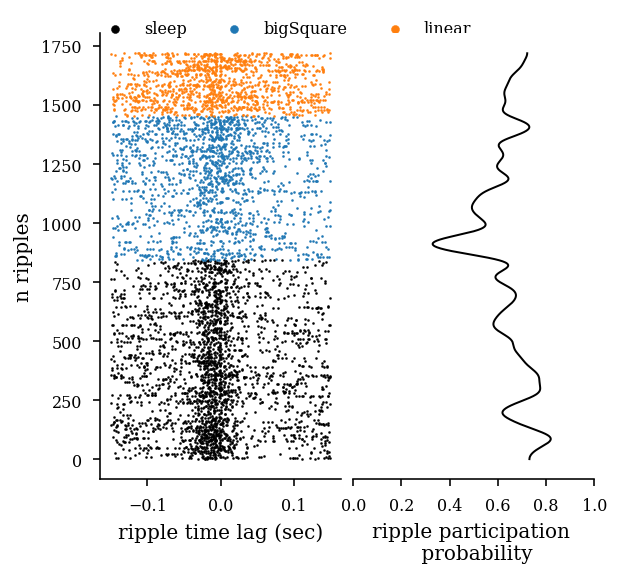

In [102]:
X = []
Y = []
for epoch_n in range(epoch_df.shape[0]):
    peak_time = ripples.peaks
    peak_time = peak_time[(peak_time >= epoch_df.iloc[epoch_n].startTime) & (peak_time <= epoch_df.iloc[epoch_n].stopTime)]
    x, y = get_raster_points(spikes,peak_time)  
    X.append(x)
    Y.append(y)

X = np.array(X,dtype=object)
Y = np.array(Y,dtype=object)

y_adj = []
y_adj.append(Y[0])
for i in np.arange(1,len(X)):
    y_adj.append(Y[i] + max(y_adj[i-1]))
# y_adj = np.hstack(y_adj)
# X = np.hstack(X)

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1.5,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.05)
axs = axs.ravel()

for i in np.arange(0,len(X)):
    if epoch_df.iloc[i].environment == "sleep":
        axs[0].scatter(X[i],y_adj[i],s=1,color="k",label=epoch_df.iloc[i].environment)  
    else:
        axs[0].scatter(X[i],y_adj[i],s=1,label=epoch_df.iloc[i].environment)  

axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
# axs[0].legend(bbox_to_anchor=(1, .1, 0.5, .5),frameon=False,ncol=5,labelspacing=.1)
axs[0].legend(bbox_to_anchor=[1.6, 1.01], loc='center right',frameon=False,ncol=3,labelspacing=.1,markerscale=4)
#  bbox_to_anchor=(0.5, 0., 0.5, 0.5)
axs[0].set_ylabel('n ripples')
axs[0].set_xlabel('ripple time lag (sec)')
# axs[0].axvline(0,color="grey",zorder=-100)

axs[1].plot(unit_particip_sm, np.arange(len(unit_particip_sm)),color="k",linewidth=1,zorder=-1000)
axs[1].set_xlim(0,1)
axs[1].axes.yaxis.set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].set_xlabel('ripple participation \n probability')

# axs[1].axhspan(epoch_df.iloc[1].startTime,epoch_df.iloc[1].stopTime)
# ax = plt.gca()
# plt.savefig(os.path.join(fig_save_path,'participation_epoch_stability_example_high_par.svg'),dpi=300,bbox_inches='tight')


In [71]:
df_save[(df_save.par_mean > .6) & (df_save.par_std < .1)]

,par_mean_diff,par_std,par_mean,par_median,basepath,UID,deepSuperficial,n_spikes_mean,avg_fr_not_rip,avg_fr_in_rip,mean_n_ripples
11,-0.019701,0.051608,0.631644,0.646617,Z:\Data\Kenji\ec013.152_157,72,Deep,4575.809524,1.873206,9.557184,573.333333
22,0.023915,0.072528,0.615744,0.593750,Z:\Data\Kenji\ec013.194_213,81,Deep,4593.740000,1.146018,6.578378,1117.800000
38,-0.020655,0.063334,0.811334,0.803674,Z:\Data\Kenji\ec013.370_390,83,Deep,3119.312500,1.223853,10.598985,374.375000


Text(0.5, 0, 'ripple participation \n probability')

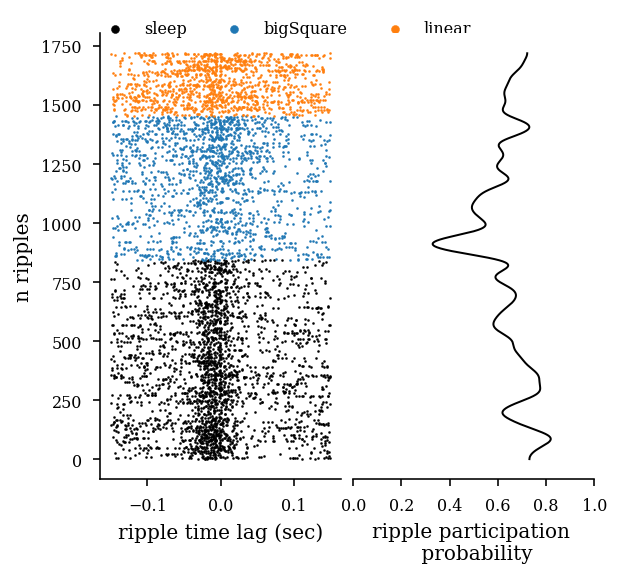

In [574]:
df_save[df_save.par_mean > .6]

basepath = 'Z:\Data\Kenji\ec013.152_157'
UID = 72

cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

epoch_df = loading.load_epoch(basepath)
epoch_df = compress_repeated_epochs(epoch_df)

spikes = data['spikes'][np.where(cell_metrics.UID == UID)[0][0]]


unit_particip = np.zeros(ripples.shape[0])
unit_fr= np.zeros_like(unit_particip)

for i,rip in enumerate(ripples.itertuples()):
    unit_particip[i] = np.any((spikes >= rip.start) & (spikes <= rip.stop))
    unit_fr[i] = np.sum((spikes >= rip.start) & (spikes <= rip.stop)) / rip.duration

# unit_particip_sm = gaussian_filter1d(unit_particip,10)
unit_particip_sm = gaussian_filter1d(unit_particip,30)


X = []
Y = []
for epoch_n in range(epoch_df.shape[0]):
    peak_time = ripples.peaks
    peak_time = peak_time[(peak_time >= epoch_df.iloc[epoch_n].startTime) & (peak_time <= epoch_df.iloc[epoch_n].stopTime)]
    x, y = get_raster_points(spikes,peak_time)  
    X.append(x)
    Y.append(y)

X = np.array(X,dtype=object)
Y = np.array(Y,dtype=object)

y_adj = []
y_adj.append(Y[0])
for i in np.arange(1,len(X)):
    y_adj.append(Y[i] + max(y_adj[i-1]))

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1.5,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.05)
axs = axs.ravel()

for i in np.arange(0,len(X)):
    if epoch_df.iloc[i].environment == "sleep":
        axs[0].scatter(X[i],y_adj[i],s=1,color="k",label=epoch_df.iloc[i].environment)  
    else:
        axs[0].scatter(X[i],y_adj[i],s=1,label=epoch_df.iloc[i].environment)  

axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
# axs[0].legend(bbox_to_anchor=(1, .1, 0.5, .5),frameon=False,ncol=5,labelspacing=.1)
axs[0].legend(bbox_to_anchor=[1.6, 1.01], loc='center right',frameon=False,ncol=3,labelspacing=.1,markerscale=4)
#  bbox_to_anchor=(0.5, 0., 0.5, 0.5)
axs[0].set_ylabel('n ripples')
axs[0].set_xlabel('ripple time lag (sec)')
# axs[0].axvline(0,color="grey",zorder=-100)

axs[1].plot(unit_particip_sm, np.arange(len(unit_particip_sm)),color="k",linewidth=1,zorder=-1000)
axs[1].set_xlim(0,1)
axs[1].axes.yaxis.set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].set_xlabel('ripple participation \n probability')

# Pairwise correlation analysis

In [508]:
n_units = []
for basepath in df.basepath:
    n_units.append(df[(df.basepath == basepath) & (df.epoch_n == df[df.basepath == basepath].epoch_n.iloc[0])].shape[0])

In [509]:
def pairwise_corr(df):
    x = df.epoch_n.unique()
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    x = []
    x1 = []
    for i,s in enumerate(c):
        x.append(df[df.epoch_n==s[0]].participation_prob.values)	
        x1.append(df[df.epoch_n==s[1]].participation_prob.values)

        rho_, pval_ = stats.spearmanr(df[df.epoch_n==s[0]].participation_prob,
                                        df[df.epoch_n==s[1]].participation_prob)
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c,x,x1

df_save = pd.DataFrame()
X1 = []
X2 = []
for basepath in df[np.array(n_units)>=7].basepath.unique():
    if df[(df.basepath == basepath)].epoch_n.unique().shape[0] > 1:
        rho,pval,c,x,x1 = pairwise_corr(df[(df.basepath == basepath)])
        X1.append(x)
        X2.append(x1)
        
        temp_df = pd.DataFrame()

        temp_df['ref'] = c[:,0]
        temp_df['target'] = c[:,1]
        temp_df['rho'] = rho
        temp_df['pval'] = pval
        temp_df['basepath'] = basepath

        df_save = df_save.append(temp_df,ignore_index=True)
# df_save

In [282]:
# from sklearn.linear_model import RANSACRegressor

# # x1 = np.expand_dims(x1,axis=0)
# reg = RANSACRegressor(random_state=0).fit(np.expand_dims(x1,axis=1), x2)
# reg.score(np.expand_dims(x1,axis=1),x2)
# reg.predict(np.expand_dims(x1,axis=1))

# plt.plot(x1,reg.predict(np.expand_dims(x1,axis=1)))

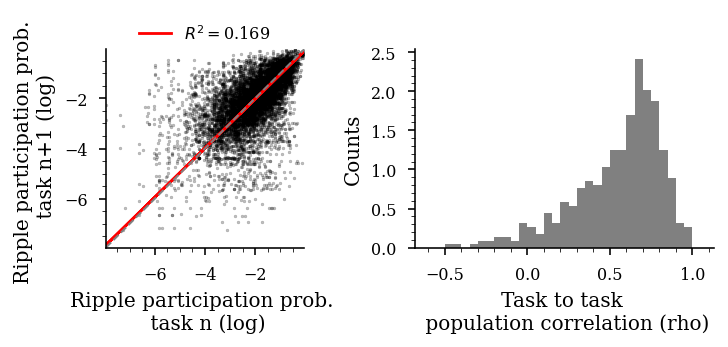

In [553]:
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import RANSACRegressor

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=1, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.2)
axs = axs.ravel()

x1 = np.hstack(list(itertools.chain(*X1)))
x2 = np.hstack(list(itertools.chain(*X2)))

idx = (x1>0 ) & (x2>0)
x1 = np.log(x1[idx])
x2 = np.log(x2[idx])

reg = RANSACRegressor(random_state=0).fit(np.expand_dims(x1,axis=1), x2)
reg.score(np.expand_dims(x1,axis=1),x2)
reg.predict(np.expand_dims(x1,axis=1))

slope, intercept_, r_value, p_value, std_err_ = stats.linregress(x1,x2)

axs[0].scatter(x1,x2,s=2,color='k',alpha=.25,rasterized=True)
# axs[0].plot(x1,x1*slope+intercept_,color='r',label='$R^2=$'+str('%.3f'%(r_value)))
# axs[0].plot(x1,reg.predict(np.expand_dims(x1,axis=1)),color='r',label='$R^2=$'+str('%.3f'%(reg.score(np.expand_dims(x1,axis=1),x2))))
axs[0].plot(x1,x1*reg.estimator_.coef_+reg.estimator_.intercept_,
            color='r',
            label='$R^2=$'+str('%.3f'%(reg.score(np.expand_dims(x1,axis=1),x2))))

axs[0].set_xlim(np.array([x1,x2]).min(),np.array([x1,x2]).max())
axs[0].set_ylim(np.array([x1,x2]).min(),np.array([x1,x2]).max())
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes,color='grey',ls='--',linewidth=1)

axs[0].set_xlabel('Ripple participation prob. \n task n (log)')
axs[0].set_ylabel('Ripple participation prob. \n task n+1 (log)')
axs[0].set_aspect('equal')

axs[1].hist(df_save.rho,bins=np.arange(-.6,1.1,.05),color='grey',density=True)
# bins = np.arange(-1,1,.05)
# axs[1].set_xlim(0,1)
axs[1].set_xlabel('Task to task \n pop. correlation (rho)')
axs[1].set_ylabel('Counts')

# axs[0].legend(frameon=False)
# axs[0].legend(loc='best',frameon=False)
axs[0].legend(bbox_to_anchor=(1, 0, -.1, 1.2),frameon=False)

for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'participation_epoch_stability_correlations.pdf'),dpi=300,bbox_inches='tight')
  
# for i, label in enumerate(('A','B', 'C', 'D','E')):
#     axs[i].text(-0.3, 1.15, label, transform=axs[i].transAxes,
#         fontsize=11, fontweight='normal', va='top', ha='right')

Z:\Data\Kenji\ec013.393_418


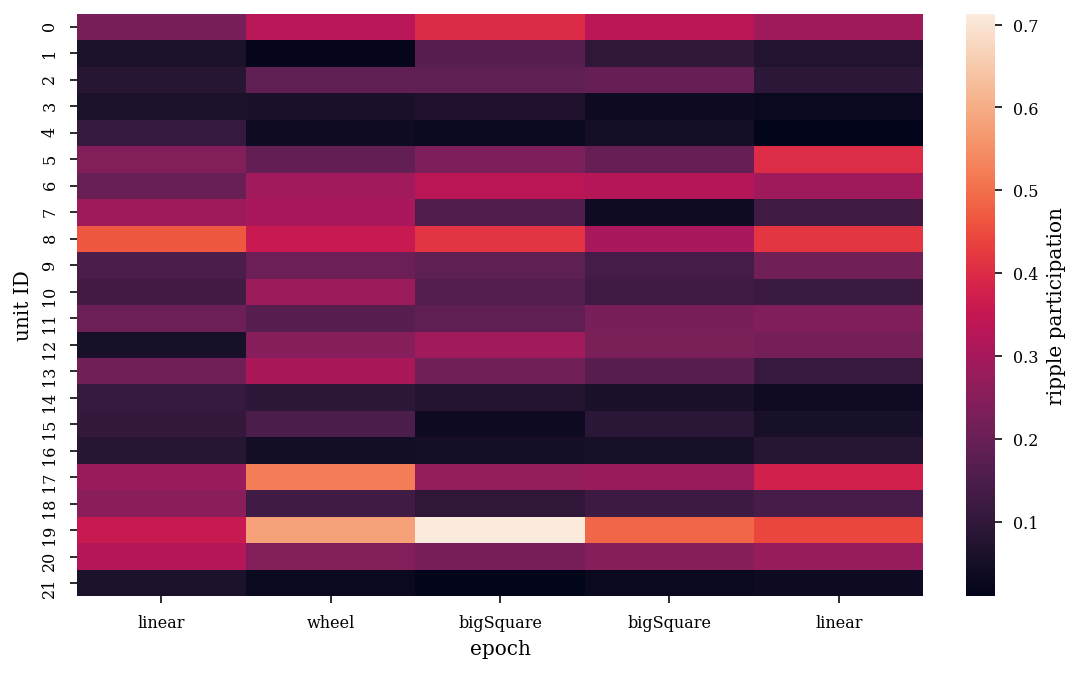

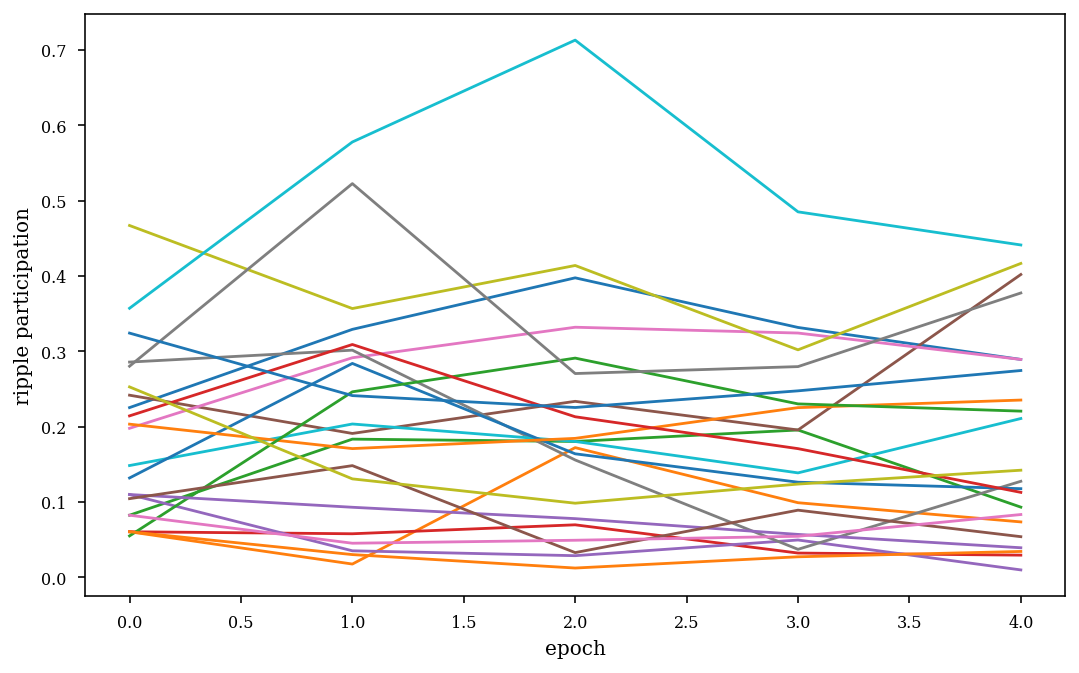

In [133]:
basepath = df[np.array(n_units)>=7].basepath.unique()[3]

print(basepath)
epoch_df = loading.load_epoch(basepath)

temp_df = df[df.basepath == basepath]
X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
for i,ep in enumerate(temp_df.epoch_n.unique()):
    X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values

epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]

X_df = pd.DataFrame(index = np.arange(X.shape[1]), columns = epoch_name)
X_df[:] = X.T

# plt.figure(figsize=(15,8))
plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
sns.heatmap(X_df,cbar_kws={'label': 'ripple participation'})
plt.ylabel('unit ID')
plt.xlabel('epoch')   

plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
plt.plot(X_df.values.T)
plt.ylabel('ripple participation')
plt.xlabel('epoch')
plt.show()

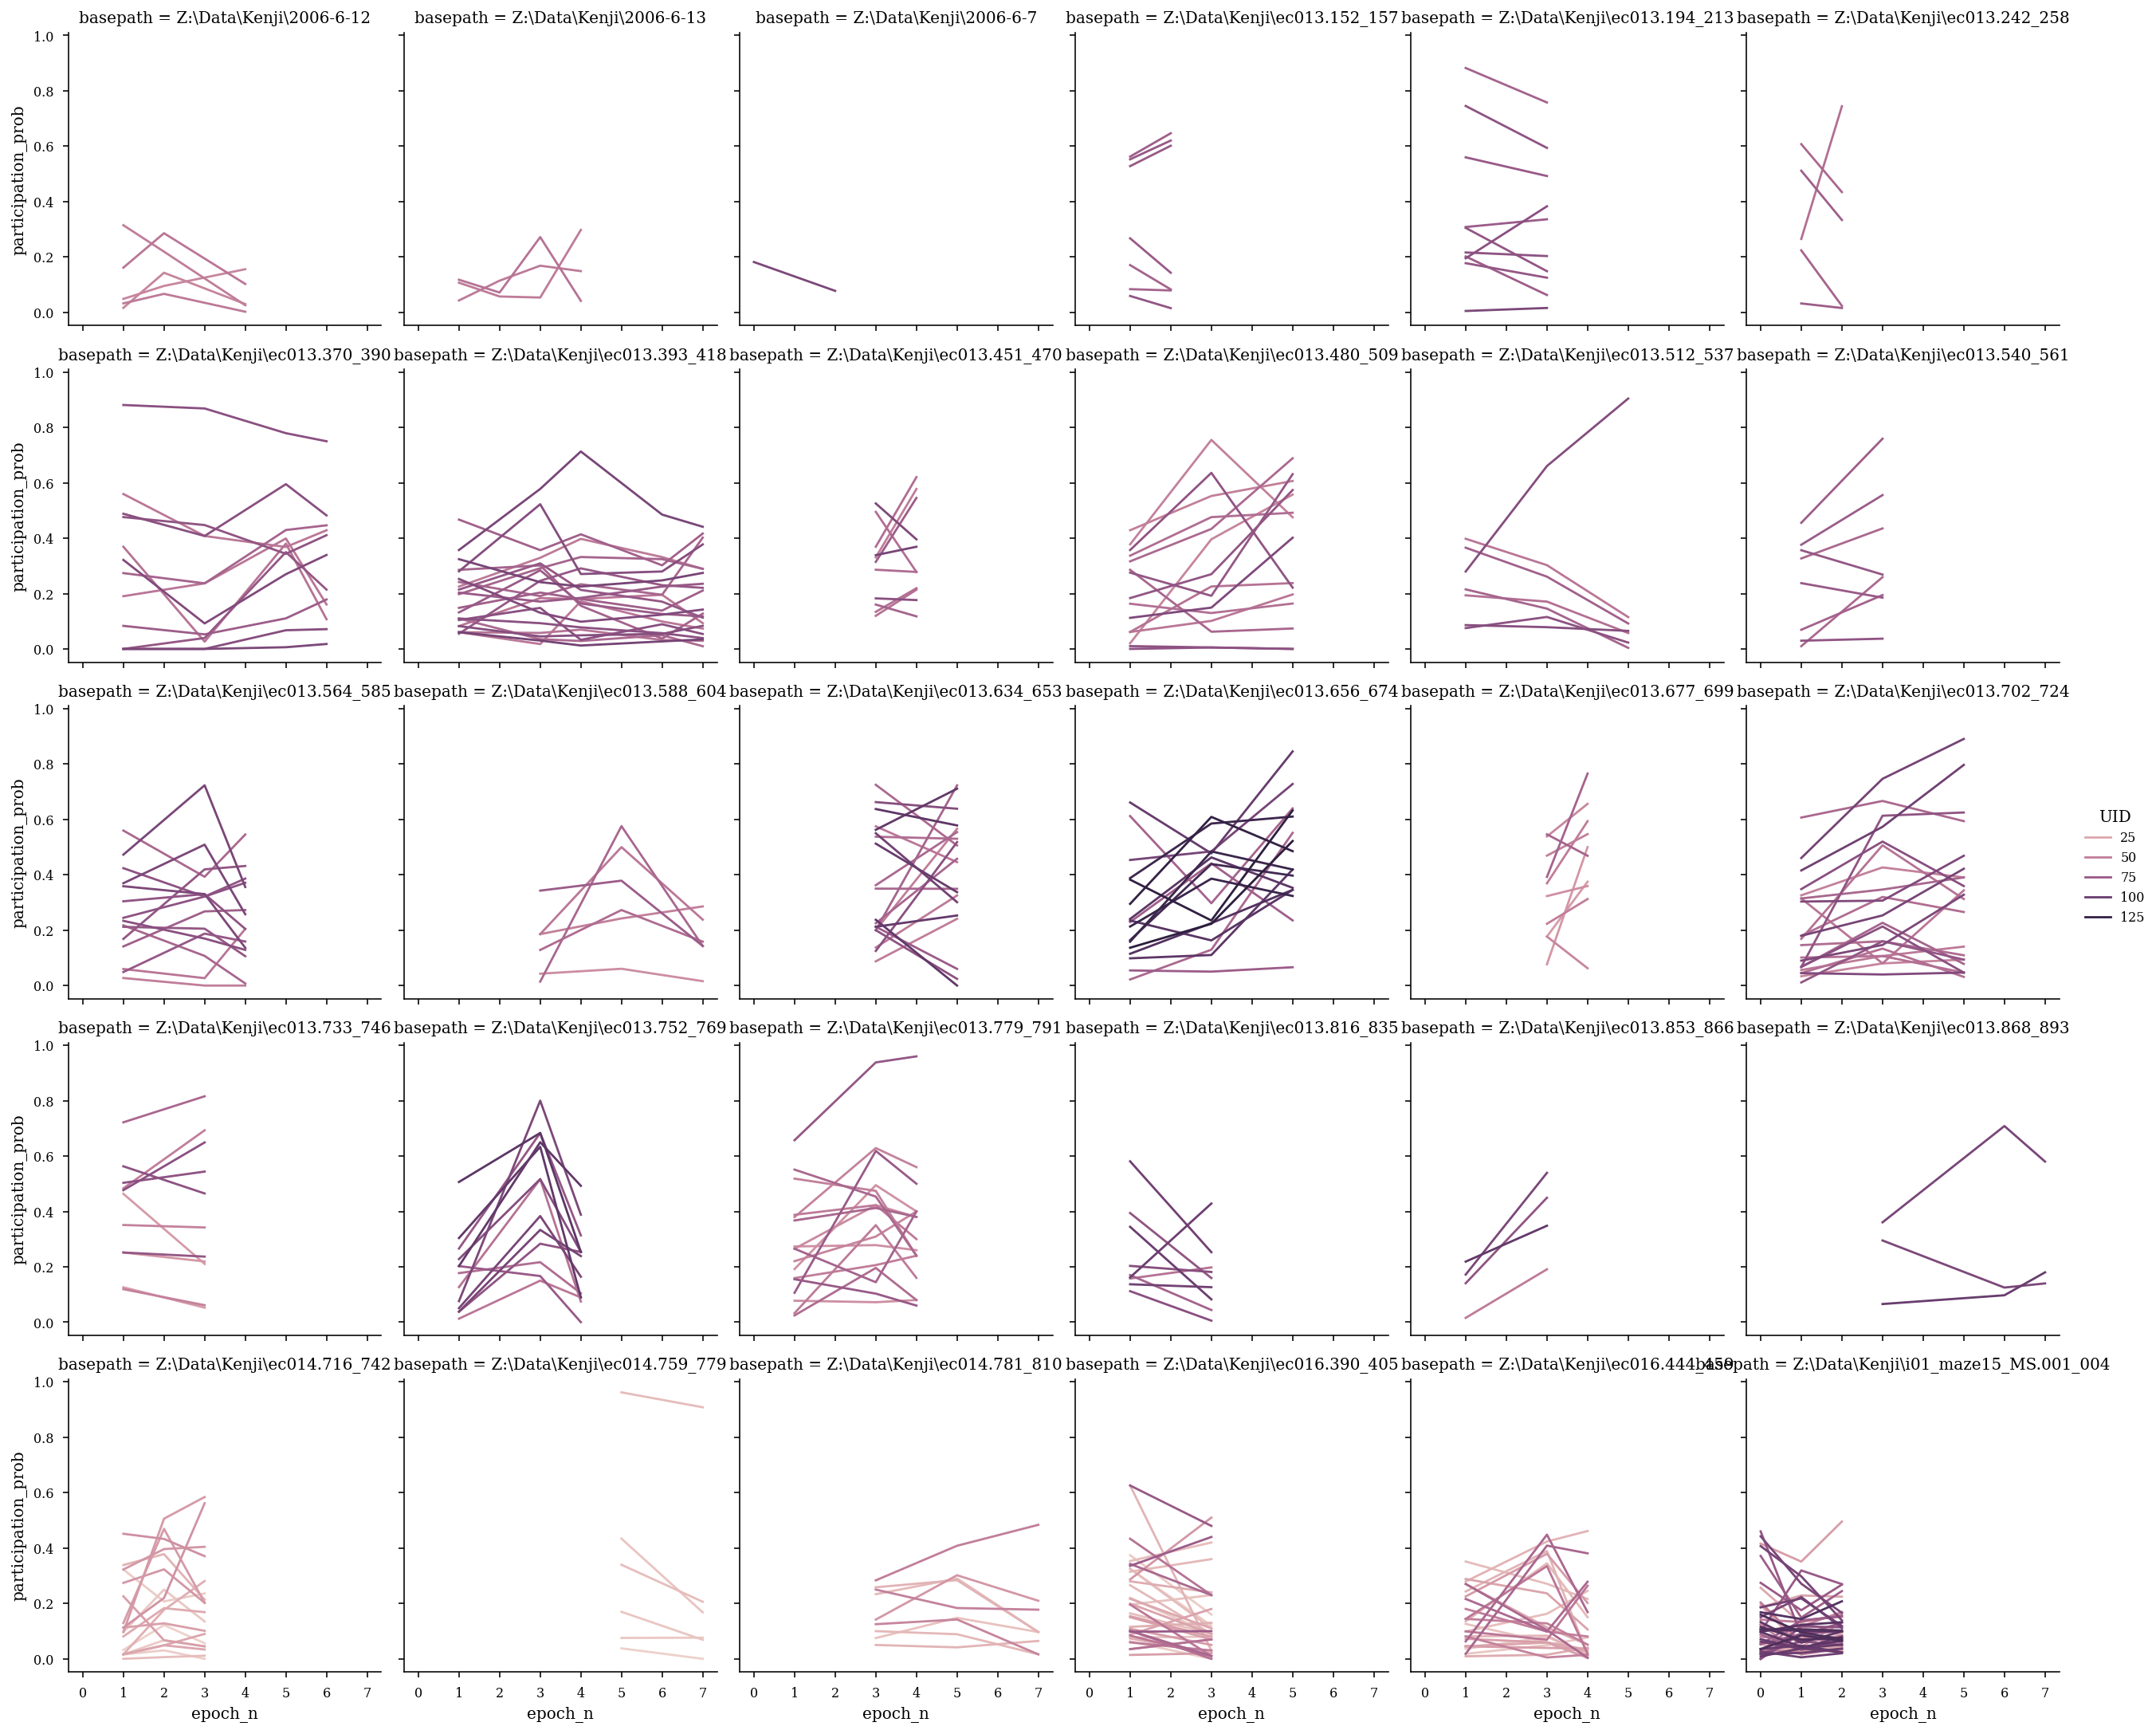

In [134]:
palette = sns.color_palette("rocket_r")

sns.relplot(
    data=df,
    x="epoch_n", y="participation_prob",
    kind="line", col="basepath",hue="UID",
    height=3, aspect=1,col_wrap=6
)